In [1]:
import traffic_light_classifier as tlc


Importing package 'traffic_light_classifier'...

 + Adding subpackage '__auxil_subpkg__'...
   + Adding submodule '__auxil_subpkg__._auxil_submod'...

 + Adding subpackage '__dependencies_subpkg__'...
   + Adding submodule '__dependencies_subpkg__._dependencies_submod'...
   - Done!
 - Done!

 + Adding subpackage '__constants_subpkg__'...
   + Adding submodule '__constants_subpkg__._constants_submod'...
   - Done!
 - Done!
   - Done!
   + Adding submodule '__auxil_subpkg__._helpers_submod'...
   - Done!
 - Done!
   + Adding submodule '__auxil_subpkg__.helpers'...
   - Done!

 + Adding subpackage '__tests_subpkg__'...
   + Adding submodule '__tests_subpkg__._tests_submod'...

 + Adding subpackage '__data_subpkg__'...
   + Adding submodule '__data_subpkg__._data_submod'...
   - Done!
 - Done!
   - Done!
 - Done!
   + Adding submodule '__tests_subpkg__.test_functions'...
   - Done!

 + Adding subpackage '_plots_subpkg'...
   + Adding submodule '_plots_subpkg._plots_submod'...
   - Done!


In [2]:
# dir(tlc)

# Traffic Light Classifier
---

In this project, I have used my knowledge of computer vision techniques to build a classifier for images of traffic lights! We have given dataset of traffic light images in which one of three lights is illuminated: Red, Yellow, or Green.

In this notebook, we will pre-process these images, extract features that will help us distinguish the different types of images, and use those features to classify the traffic light images into three classes: Red, Yellow, or Green. The tasks will be broken down into a few sections:

1. **Loading and visualizing the data**. 
      The first step in any classification task is to be familiar with our data; we will need to load in the images of traffic lights and visualize them!

2. **Pre-processing**. 
    The input images and output labels need to be standardized. This way, we can analyze all the input images using the same classification pipeline, and we know what output to expect when we eventually classify a *new* image.
    
3. **Feature extraction**. 
    Next, we will extract some features from each image that will help distinguish and eventually classify these images.
   
4. **Classification and visualizing error**. 
    Finally, we will write one function that uses your features to classify *any* traffic light image. This function will take in an image and output a label. We will also write a code to determine the accuracy of your classification model.   
    
5. **Evaluate your model**.
    Our classifier must be >90% accurate and never classify any red lights as green; it's likely that we will need to improve the accuracy of your classifier by changing existing features or adding new features.
    
Here are some sample images from the dataset (from left to right: Red, Green, and Yellow traffic lights):
<img src="images/all_lights.png" width="50%" height="50%">


# 1. Loading and Visualizing the Traffic Light Dataset

This traffic light dataset consists of 1484 number of color images in 3 categories - Red, Yellow, and Green. As with most human-sourced data, the data is not evenly distributed among the types. There are:
* 904 red traffic light images
* 536 green traffic light images
* 44 yellow traffic light images

*Note: All images come from this [MIT self-driving car course](https://selfdrivingcars.mit.edu/) and are licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/).*

### Import resources

In [3]:
import traffic_light_classifier as tlc
import cv2 # computer vision library
# import helpers # helper functions
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # for loading in images
# %matplotlib inline

## Training and Testing Data

All 1484 of the traffic light images are separated into training and testing datasets. 

* 80% of these images are training images, for us to use as you create a classifier.
* 20% are test images, which will be used to test the accuracy of your classifier.
* All images are pictures of 3-light traffic lights with one light illuminated.

## Define the image directories

First, we set some variables to keep track of some where our images are stored:

    IMAGE_DIR_TRAINING: the directory where our training image data is stored
    IMAGE_DIR_TEST: the directory where our test image data is stored

In [4]:
# Image data directories >>
IMAGE_DIR_TRAINING = "traffic_light_images/training/"
IMAGE_DIR_TEST     = "traffic_light_images/test/"

## Load the datasets

These first few lines of code will load the training traffic light images and store all of them in a variable, `IMAGES_TRAIN`. This list contains the images and their associated label ("red", "yellow", "green"). 

We are using [glob library](https://pymotw.com/2/glob/) to read image files from a directory. The `load_dataset` function takes in the name of an image directory and returns a list of images and their associated labels. 

For example, the first image-label pair in `IMAGES_TRAIN` can be accessed by index: 
``` IMAGES_TRAIN[0][:]```.


In [5]:
# Loading training data >>
# IMAGES_TRAIN = helpers.load_dataset(IMAGE_DIR_TRAINING)
IMAGES_TRAIN = tlc.helpers.load_dataset(IMAGE_DIR_TRAINING)

## Visualize the Data

The first steps in analyzing any dataset are to:

1. Load the data.
2. Look at the data.

Seeing what it looks like will give us an idea of:

- What to look for in the images.
- What kind of noise or inconsistencies we have to deal with, and so on.

This will help us understand the image dataset, and **understanding a dataset is part of making predictions about the data**.

---
### Visualize the input images

Visualize and explore the image data!
* Display the image
* Print out the shape of the image 
* Print out its corresponding label

In [6]:
IMAGES_TRAIN_red    = [ image for image in IMAGES_TRAIN if image[1] == "red" ]
IMAGES_TRAIN_yellow = [ image for image in IMAGES_TRAIN if image[1] == "yellow" ]
IMAGES_TRAIN_green  = [ image for image in IMAGES_TRAIN if image[1] == "green" ]

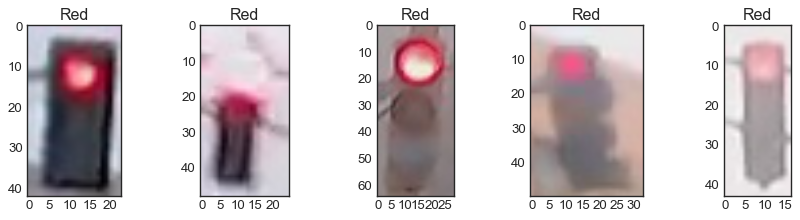

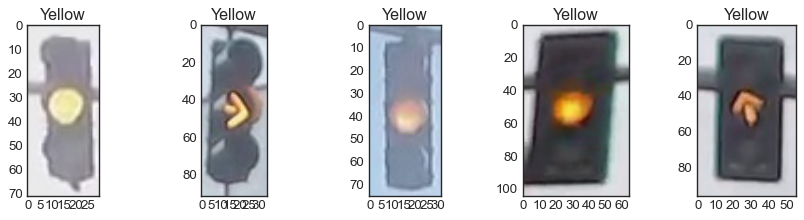

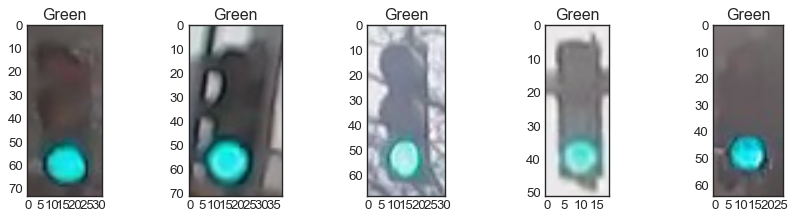

In [7]:
# Visualizing images of different color >>
tlc.plots.plot_images( IMAGES_TRAIN_red[0:5],    title_enabled = True, figsizeScale = 0.8 )
tlc.plots.plot_images( IMAGES_TRAIN_yellow[0:5], title_enabled = True, figsizeScale = 0.8 )
tlc.plots.plot_images( IMAGES_TRAIN_green[0:5],  title_enabled = True, figsizeScale = 0.8 )

# 2. Pre-process the Data

After loading in each image, we have to standardize the input and output!

### Input

This means that every input image should have:

1. The same format,
2. The same size, and so on.

We'll be creating features by performing the same analysis on every picture, and for a classification task like this, it's important that **similar images create similar features**! 

### Output

We also need the output to be a label that is easy to read and easy to compare with other labels. It is good practice to convert categorical data like "red" and "green" to numerical data.

A very common classification output is a 1D list that is the length of the number of classes - three in the case of red, yellow, and green lights - with the values 0 or 1 indicating which class a certain image is.  

For example, since we have three classes (red, yellow, and green), we can make a list with the order: [red value, yellow value, green value]. In general, order does not matter, we choose the order [red value, yellow value, green value] in this case to reflect the position of each light in descending vertical order.

Lights should have labels:  
A red light: [1, 0, 0].  
A yellow light: [0, 1, 0].  
A green light: [0, 0, 1].  

These labels are called **one-hot encoded labels**.

*(Note: one-hot encoding will be especially important when you work with [machine learning algorithms](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/)).*

<img src="images/processing_steps.png" width="80%" height="80%">


---
<a id='task2'></a>
### Standardize the input images

* Resize each image to the desired input size: 32x32px.
It's very common to have square input sizes that can be rotated (and remain the same size), and analyzed in smaller, square patches. It's also important to make all your images the same size so that they can be sent through the same pipeline of classification steps!

### Standardize the output

With each loaded image, we also specify the expected output. For this, we use **one-hot encoding**.

* One-hot encode the labels. To do this, create an array of zeros representing each class of traffic light (red, yellow, green), and set the index of the expected class number to 1. 

Since we have three classes (red, yellow, and green), we have imposed an order of: [red value, yellow value, green value]. To one-hot encode, say, a yellow light, we would first initialize an array to [0, 0, 0] and change the middle value (the yellow value) to 1: [0, 1, 0].


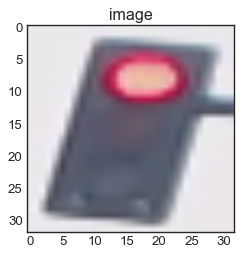

In [8]:
image_std = tlc.modify_images.standardize_image(IMAGES_TRAIN[10][0])
tlc.plots.plot_images(image_std)

---
<a id='task3'></a>
### One-hot encoding

In [9]:
# help(tlc.helpers.one_hot_encode)

One hot encode = [1, 0, 0]


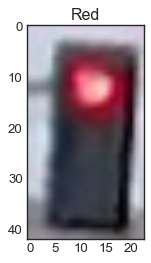

In [10]:
i_image = 0
tlc.plots.plot_images( IMAGES_TRAIN[i_image] )
encode = tlc.helpers.one_hot_encode( IMAGES_TRAIN[i_image][1] )
print(f"One hot encode = {encode}")

In [11]:
tlc.helpers.one_hot_encode_reverse( encode )

'Red'

### Testing as you Code

After programming a function, it's a good idea to test it, and see if it produces the expected output. **In general, it's good practice to test code in small, functional pieces, after you write it**. This way, we can make sure that your code is correct as we continue to build a classifier, and we can identify any errors early on so that they don't compound.

All test code can be found in the file `__tests_subpkg__.test_functions.py`.

One test function you'll find is: `test_one_hot(self, one_hot_function)` which takes in one argument, a one_hot_encode function, and tests its functionality. If our one_hot_label code does not work as expected, this test will print ot an error message that will tell us a bit about why our code failed. Once our code works, this should print out TEST PASSED.

In [12]:
# Instantiating an object of class 'Tests' from module 'test_functions'.
tests = tlc.test_functions.Tests()

# Test for one_hot_encode function
tests.test_one_hot(tlc.helpers.one_hot_encode)


**<span style="color: green;">TEST PASSED</span>**

## Construct a `STANDARDIZED_LIST` of input images and output labels.

This function takes in a list of image-label pairs and outputs a **standardized** list of resized images and one-hot encoded labels.

This uses the functions we defined above to standardize the input and output, so those functions must be complete for this standardization to work!


In [13]:

images_train_std        = tlc.modify_images.standardize_images(IMAGES_TRAIN)
images_train_std_red    = tlc.modify_images.standardize_images(IMAGES_TRAIN_red)
images_train_std_yellow = tlc.modify_images.standardize_images(IMAGES_TRAIN_yellow)
images_train_std_green  = tlc.modify_images.standardize_images(IMAGES_TRAIN_green)

images_test = tlc.helpers.load_dataset(IMAGE_DIR_TEST)
images_test_red    = [ image for image in images_test if image[1] == "red" ]
images_test_yellow = [ image for image in images_test if image[1] == "yellow" ]
images_test_green  = [ image for image in images_test if image[1] == "green" ]

images_test_std = tlc.modify_images.standardize_images(images_test)
images_test_std_red    = tlc.modify_images.standardize_images(images_test_red)
images_test_std_yellow = tlc.modify_images.standardize_images(images_test_yellow)
images_test_std_green  = tlc.modify_images.standardize_images(images_test_green)


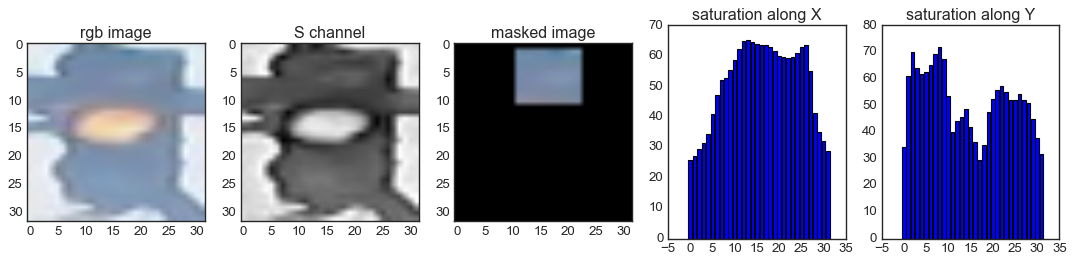

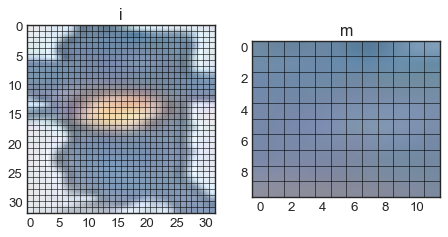

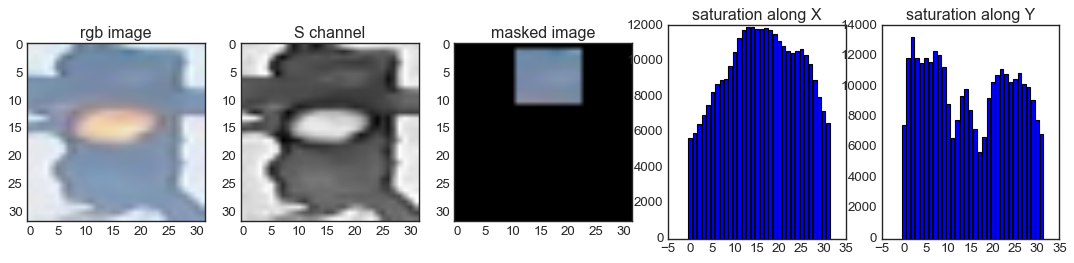

[(11, 23), (1, 11)]

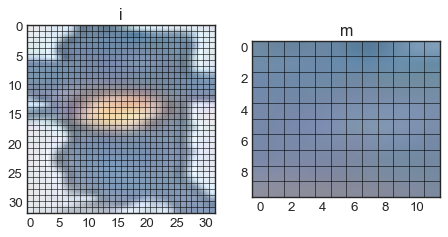

In [14]:
# image_rgb = MISCLASSIFIED[2][0]

image_rgb = random.choice(images_test_std_yellow)[0]
image_rgb = images_test_std_yellow[8][0]
len_range = (12,10)
get_range_of_high_average_channel = tlc.extract_feature.get_range_of_high_average_channel
range_s, _ = get_range_of_high_average_channel(image_rgb, "s", len_range, plot_enabled = True)

crop = tlc.modify_images.crop_image
image_cropped = crop(image_rgb, range_s[0], range_s[1], plot_enabled = True)

range_s

get_range_of_high_average_channel = tlc.extract_feature.get_range_of_high_average_channel
range_s, _ = get_range_of_high_average_channel(image_rgb, "s", len_range, extra_channel = "v", plot_enabled = True)

crop = tlc.modify_images.crop_image
image_cropped = crop(image_rgb, range_s[0], range_s[1], plot_enabled = True)

range_s


In [15]:
# # image_rgb = MISCLASSIFIED[2][0]

# len_range = (10,8)
# get_range_of_high_average_channel = tlc.extract_feature.get_range_of_high_average_channel
# range_s, _, b = get_range_of_high_average_channel(image_rgb, "s", len_range, plot_enabled = True, add_brightness = True)

# crop = tlc.modify_images.crop_image
# image_cropped = crop(image_rgb, range_s[0], range_s[1], plot_enabled = True)

# range_s

In [16]:
# a == b

## Visualize the standardized data

Displaying standardized images from STANDARDIZED_LIST and compare it with a non-standardized image from IMAGE_LIST. Note that their sizes and appearance are different!

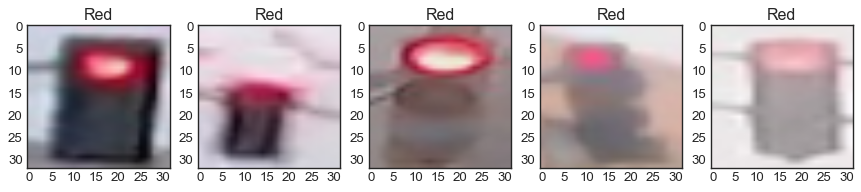

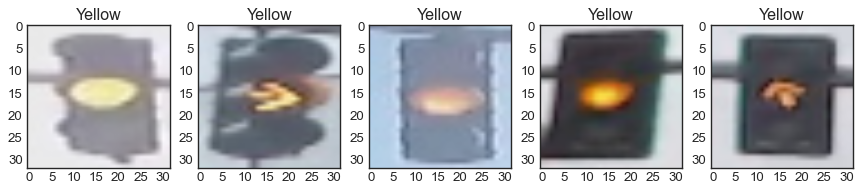

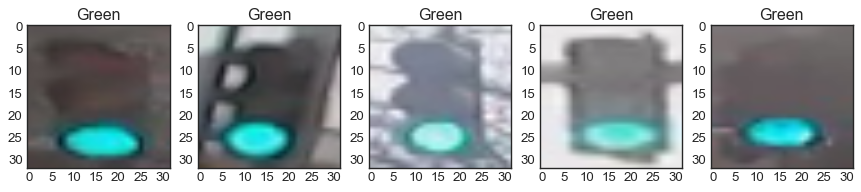

In [17]:
tlc.plots.plot_images( images_train_std_red[0:5],    figsizeScale = 0.8 )
tlc.plots.plot_images( images_train_std_yellow[0:5], figsizeScale = 0.8 )
tlc.plots.plot_images( images_train_std_green[0:5],  figsizeScale = 0.8 )

# 3. Feature Extraction

We will be using knowledge of follwing to create features that help distinguish and classify the three types of traffic light images.
1. Color spaces.
2. Shape analysis,
3. Feature construction 


1. A brightness feature.
2. Saturation feature.
3. Hue feature.
are the possible candidates from the glimps of the images so far.

These features will be combined near the end of this notebook to form a complete classification algorithm.

## Creating a brightness feature 

Pictured below is a sample pipeline for creating a brightness feature (from left to right: standardized image, HSV color-masked image, cropped image, brightness feature):

<img src="images/feature_ext_steps.png" width="70%" height="70%">


## RGB to HSV conversion

Below, a test image is converted from RGB to HSV colorspace and each component is displayed in an image.

In [18]:
images_test_green[0][0].shape[1]

18

In [19]:
i_image = 0
image_rgb       = images_train_std[i_image][0]
label_image_rgb = images_train_std[i_image][1]

### RGB Image

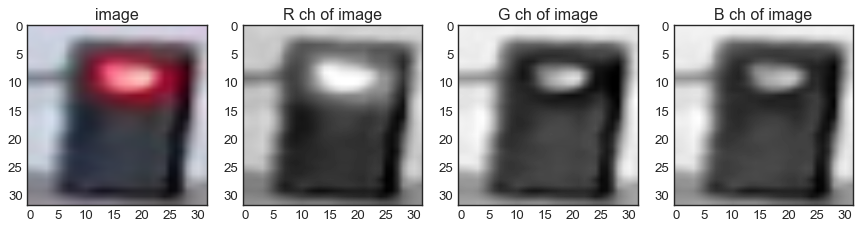

In [20]:
# plotting rgb channels
tlc.plots.plot_channels(image_rgb, type_channels = "rgb")

### RGB Image (grayscale)

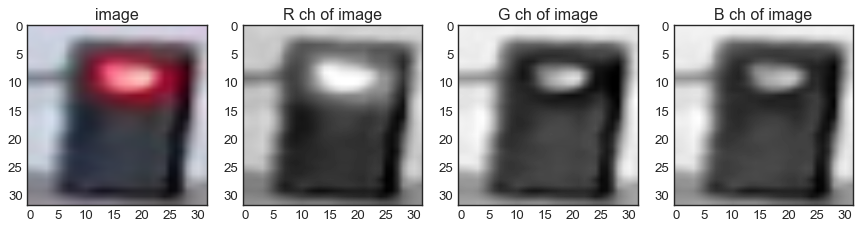

In [21]:
# plotting grayscale rgb channels
image_hsv = tlc.plots.plot_channels(image_rgb, type_channels = "rgb", cmap = "gray")

### HSV Image

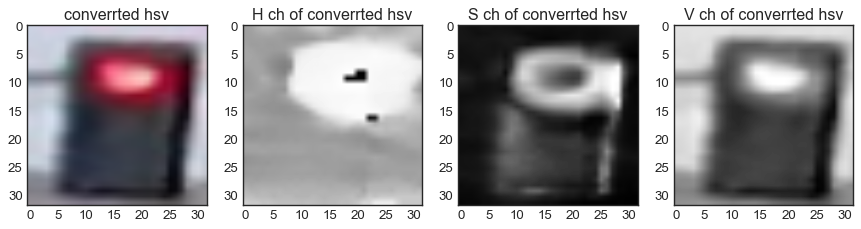

In [22]:
# plotting hsv channels
image_hsv = tlc.modify_images.convert_rgb_to_hsv(image_rgb, plot_enabled = True, cmap = None)

### HSV Image (grayscale)

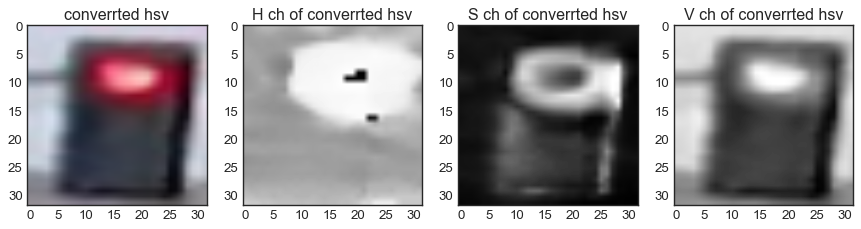

In [23]:
# plotting grayscale hsv channels
image_hsv = tlc.modify_images.convert_rgb_to_hsv(image_rgb, plot_enabled = True, cmap = "gray")

## Locating high saturation region

In [24]:
# get_range_of_high_average_channel = tlc.extract_feature.get_location_of_light
# range_XY, _ = get_range_of_high_average_channel(images_train_std[0][0], plot_enabled = True)
# print(f"Region of hish saturation is:")
# print(f"                   On X: {range_XY[0]}")
# print(f"                   On Y: {range_XY[1]}")

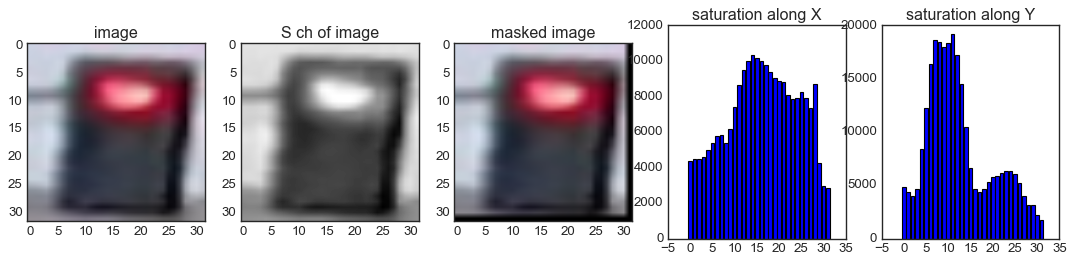

Region of hish saturation is:
                   On X: (0, 31)
                   On Y: (0, 31)


In [25]:
get_location_of_light = tlc.extract_feature.get_location_of_light
range_XY = get_location_of_light(images_train_std[0][0], plot_enabled = True)
print(f"Region of hish saturation is:")
print(f"                   On X: {range_XY[0]}")
print(f"                   On Y: {range_XY[1]}")

## Getting Average Image to estimate the average location of red, yellow & green lights

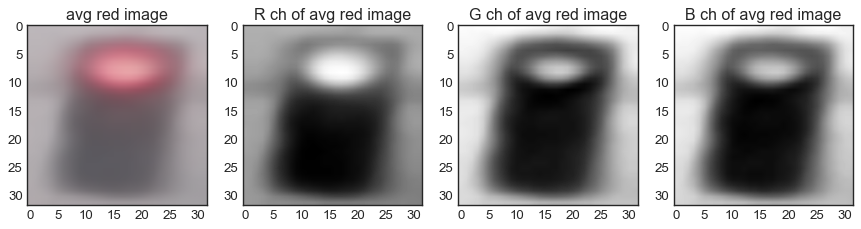

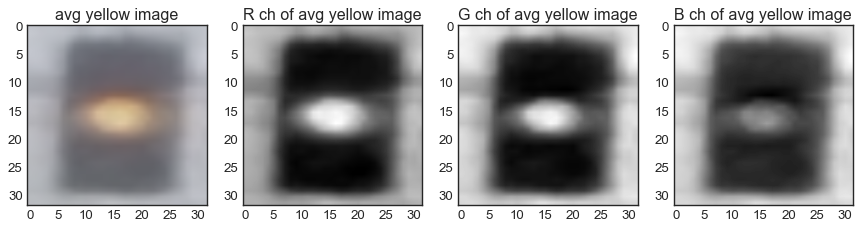

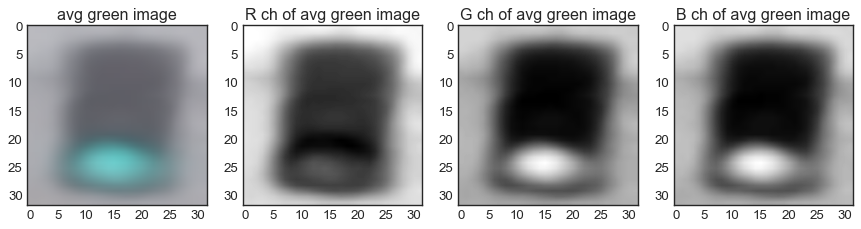

In [26]:
plot_enabled  = True
type_channels = "rgb"
image_avg_red    = tlc.extract_feature.get_average_image(images_train_std_red,    plot_enabled, type_channels, name_image = "avg red image")
image_avg_yellow = tlc.extract_feature.get_average_image(images_train_std_yellow, plot_enabled, type_channels, name_image = "avg yellow image")
image_avg_green  = tlc.extract_feature.get_average_image(images_train_std_green,  plot_enabled, type_channels, name_image = "avg green image")

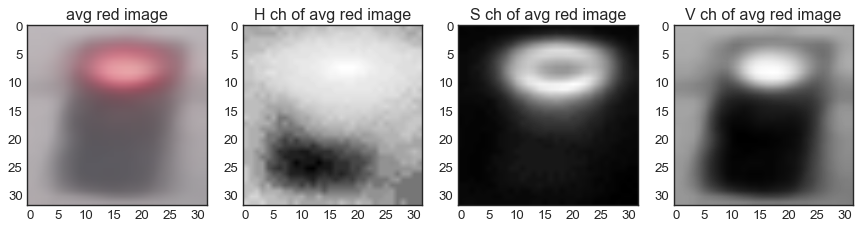

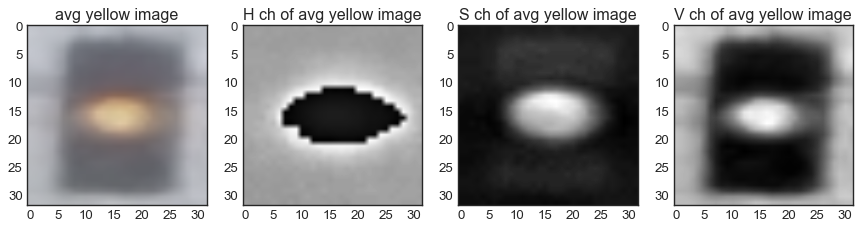

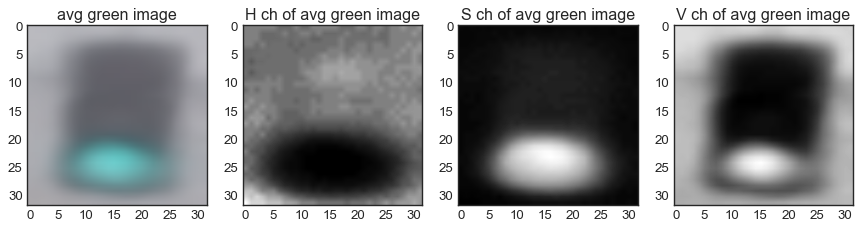

In [27]:
plot_enabled  = True
type_channels = "hsv"
image_avg_red    = tlc.extract_feature.get_average_image(images_train_std_red,    plot_enabled, type_channels, name_image = "avg red image")
image_avg_yellow = tlc.extract_feature.get_average_image(images_train_std_yellow, plot_enabled, type_channels, name_image = "avg yellow image")
image_avg_green  = tlc.extract_feature.get_average_image(images_train_std_green,  plot_enabled, type_channels, name_image = "avg green image")

### Observation in h, s, v channels of average red, yellow & green image

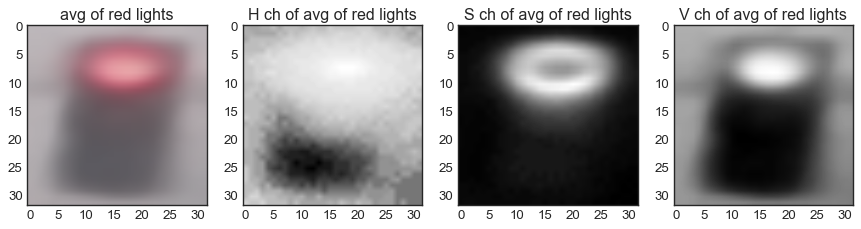

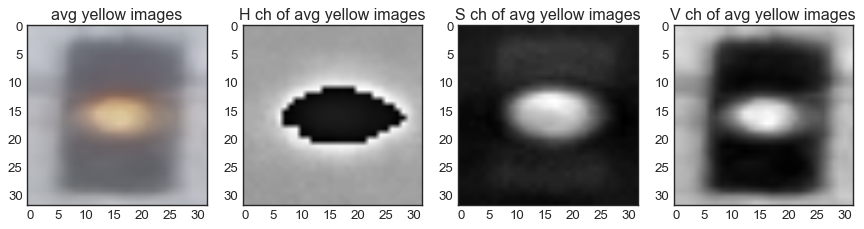

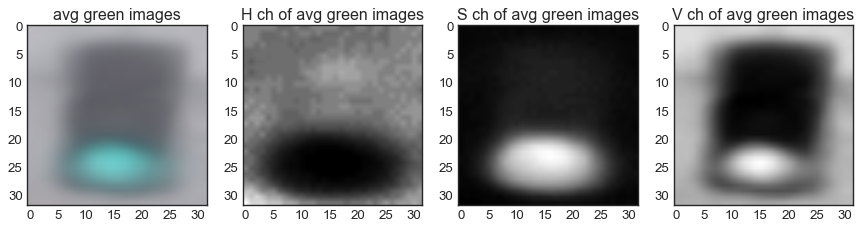

In [28]:
plot_enabled  = True
type_channels = "rgb"
image_avg_red_hsv    = tlc.modify_images.convert_rgb_to_hsv(image_avg_red,    plot_enabled, cmap = "gray", name_image = "avg of red lights")
image_avg_yellow_hsv = tlc.modify_images.convert_rgb_to_hsv(image_avg_yellow, plot_enabled, cmap = "gray", name_image = "avg yellow images")
image_avg_green_hsv  = tlc.modify_images.convert_rgb_to_hsv(image_avg_green,  plot_enabled, cmap = "gray", name_image = "avg green images")

### Observation in h, s, v channels of average red, yellow & green image

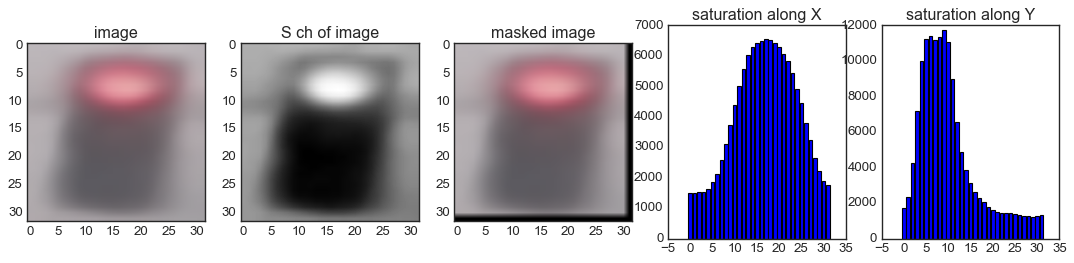

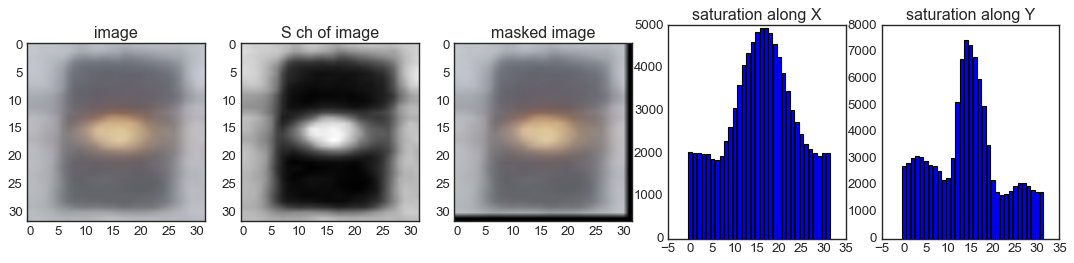

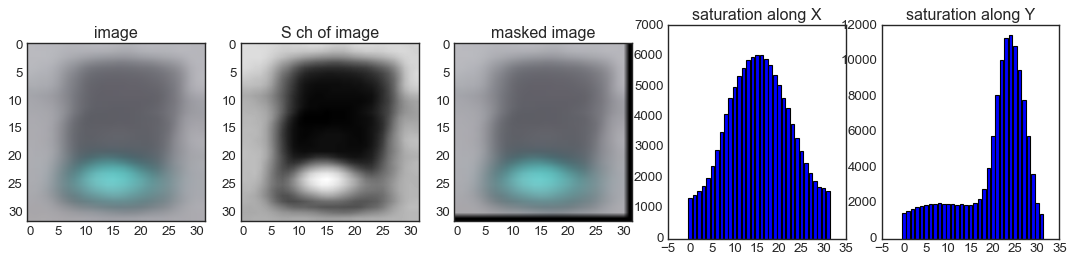

Range of high Saturation for average of Red    images: X = (0, 31), Y = (0, 31)
Range of high Saturation for average of yellow images: X = (0, 31), Y = (0, 31)
Range of high Saturation for average of green  images: X = (0, 31), Y = (0, 31)


In [29]:
range_avg_s_red    = tlc.extract_feature.get_location_of_light( image_avg_red,    plot_enabled = True)
range_avg_s_yellow = tlc.extract_feature.get_location_of_light( image_avg_yellow, plot_enabled = True)
range_avg_s_green  = tlc.extract_feature.get_location_of_light( image_avg_green,  plot_enabled = True)
print(f"Range of high Saturation for average of Red    images: X = {range_avg_s_red[0]}, Y = {range_avg_s_red[1]}")
print(f"Range of high Saturation for average of yellow images: X = {range_avg_s_yellow[0]}, Y = {range_avg_s_yellow[1]}")
print(f"Range of high Saturation for average of green  images: X = {range_avg_s_green[0]}, Y = {range_avg_s_green[1]}")

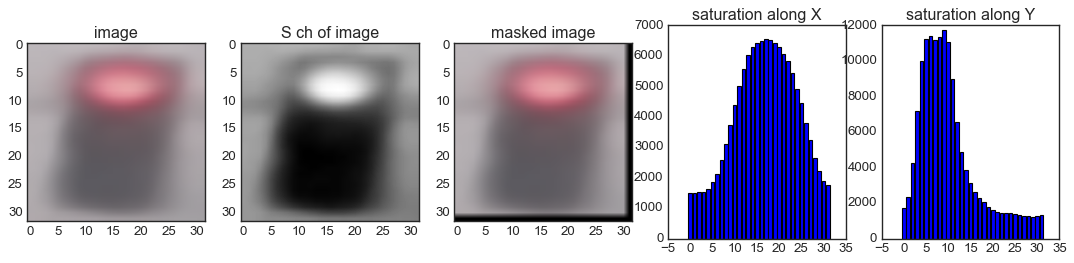

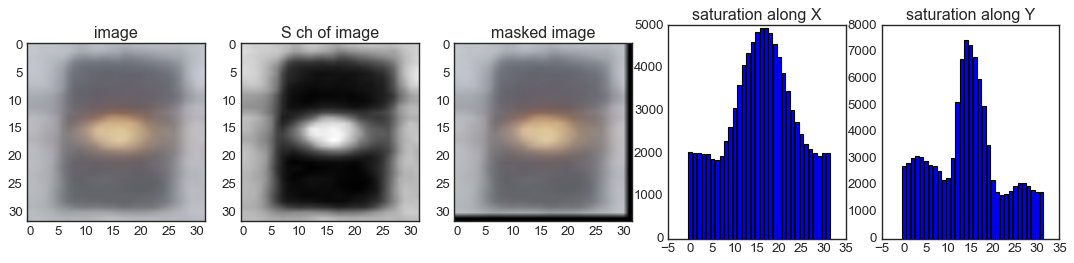

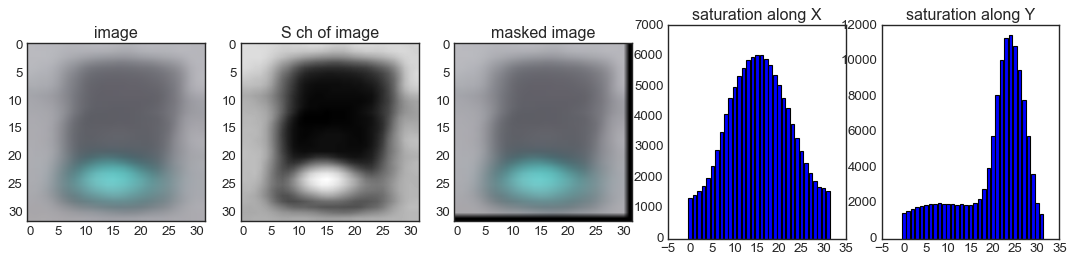

Range of high Saturation for average of Red    images: X = (0, 31), Y = (0, 31)
Range of high Saturation for average of yellow images: X = (0, 31), Y = (0, 31)
Range of high Saturation for average of green  images: X = (0, 31), Y = (0, 31)


In [30]:
range_avg_s_red    = tlc.extract_feature.get_location_of_light( image_avg_red,    plot_enabled = True)
range_avg_s_yellow = tlc.extract_feature.get_location_of_light( image_avg_yellow, plot_enabled = True)
range_avg_s_green  = tlc.extract_feature.get_location_of_light( image_avg_green,  plot_enabled = True)
print(f"Range of high Saturation for average of Red    images: X = {range_avg_s_red[0]}, Y = {range_avg_s_red[1]}")
print(f"Range of high Saturation for average of yellow images: X = {range_avg_s_yellow[0]}, Y = {range_avg_s_yellow[1]}")
print(f"Range of high Saturation for average of green  images: X = {range_avg_s_green[0]}, Y = {range_avg_s_green[1]}")

In [31]:
# image_masked_red    = tlc.modify_images.mask_image( image_avg_red,    range_avg_s_red[0],    range_avg_s_red[1]   , plot_enabled = True )
# image_masked_yellow = tlc.modify_images.mask_image( image_avg_yellow, range_avg_s_yellow[0], range_avg_s_yellow[1], plot_enabled = True )
# image_masked_green  = tlc.modify_images.mask_image( image_avg_green , range_avg_s_green[0],  range_avg_s_green[1] , plot_enabled = True )

In [32]:
# Extracting Average colrs

In [33]:
get_location_of_light = tlc.extract_feature.get_location_of_light

ranges_red    = [ get_location_of_light(image[0]) for image in images_train_std_red ]
ranges_yellow = [ get_location_of_light(image[0]) for image in images_train_std_yellow ]
ranges_green  = [ get_location_of_light(image[0]) for image in images_train_std_green ]


In [34]:
crop = tlc.modify_images.crop_image
images_cropped_red    = [ crop(image[0], ranges_red[i][0],    ranges_red[i][1])    for i, image in enumerate(images_train_std_red) ]
images_cropped_yellow = [ crop(image[0], ranges_yellow[i][0], ranges_yellow[i][1]) for i, image in enumerate(images_train_std_yellow) ]
images_cropped_green  = [ crop(image[0], ranges_green[i][0],  ranges_green[i][1])  for i, image in enumerate(images_train_std_green) ]

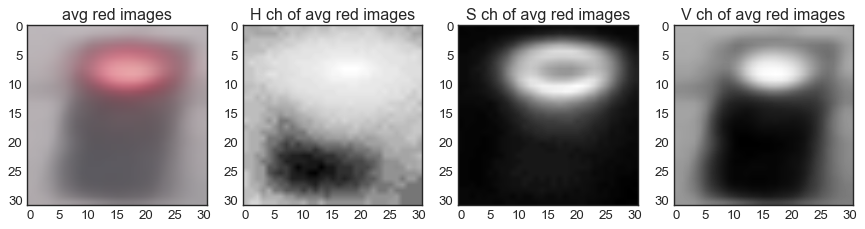

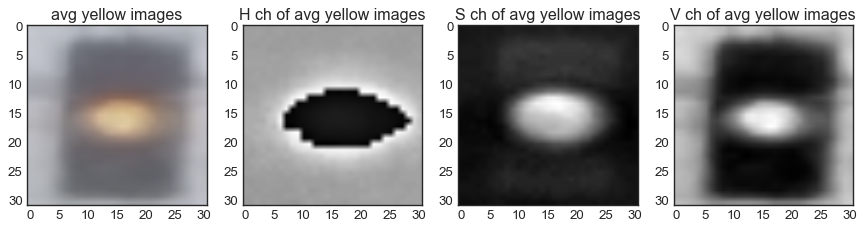

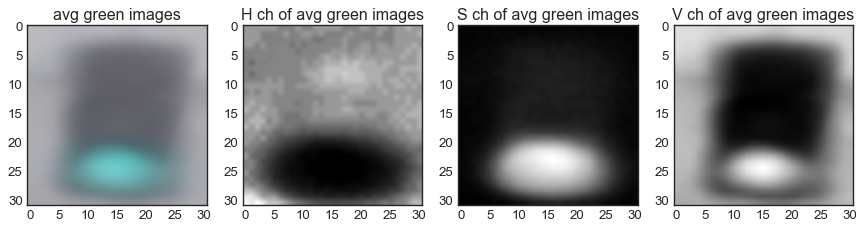

In [35]:
plot_enabled      = True
type_channels     = "rgb"
get_average_image = tlc.extract_feature.get_average_image
plot_enabled      = True
type_channels     = "hsv"
image_avg_red    = get_average_image(images_cropped_red,    plot_enabled, type_channels, name_image = "avg red images",    is_images_npArrays = True)
image_avg_yellow = get_average_image(images_cropped_yellow, plot_enabled, type_channels, name_image = "avg yellow images", is_images_npArrays = True)
image_avg_green  = get_average_image(images_cropped_green,  plot_enabled, type_channels, name_image = "avg green images",  is_images_npArrays = True)


# OLD

## Masking high saturation region

In [36]:
# image_masked_red    = tlc.modify_images.mask_image( image_avg_red,    range_avg_s_red[0],    range_avg_s_red[1]   , plot_enabled = True )
# image_masked_yellow = tlc.modify_images.mask_image( image_avg_yellow, range_avg_s_yellow[0], range_avg_s_yellow[1], plot_enabled = True )
# image_masked_green  = tlc.modify_images.mask_image( image_avg_green , range_avg_s_green[0],  range_avg_s_green[1] , plot_enabled = True )

In [37]:
# get_distribution = tlc.statistics.get_distribution_of_channel
# image    = image_avg_red
# channels = "rgb"
# rangeXY  = ranges_red
# rangeXY = ( (0, len_range[0]), (0, len_range[1]) )
# mu_R, sig_R, dist_R = get_distribution( image, channels, 0, rangeXY[0], rangeXY[1] )
# mu_Y, sig_Y, dist_Y = get_distribution( image, channels, 1, rangeXY[0], rangeXY[1] )
# mu_G, sig_G, dist_G = get_distribution( image, channels, 2, rangeXY[0], rangeXY[1] )

# print(f"Distribution of brightness in Average-Red    image: mu_R = {mu_R:.3f}, sig_R = {sig_R:.3f}")
# print(f"Distribution of brightness in Average-Yellow image: mu_Y = {mu_Y:.3f}, sig_Y = {sig_Y:.3f}")
# print(f"Distribution of brightness in Average-Green  image: mu_G = {mu_G:.3f}, sig_G = {sig_G:.3f}")

# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))

# w = 15

# ax = ax1; dist = dist_R; mu = mu_R; sig = sig_R
# ax.set_title(f"Histogram of ch r\n mu = {mu:.3f}, sig = {sig:.3f}")
# _ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 265])
# ax.set_ylim([0, 40])

# ax = ax2; dist = dist_Y; mu = mu_Y; sig = sig_Y
# ax.set_title(f"Histogram of ch g\n mu = {mu:.3f}, sig = {sig:.3f}")
# _ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 265])
# ax.set_ylim([0, 40])

# ax = ax3; dist = dist_G; mu = mu_G; sig = sig_G
# ax.set_title(f"Histogram of ch b\n mu = {mu:.3f}, sig = {sig:.3f}")
# ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 265])
# ax.set_ylim([0, 40])


In [38]:
# get_distribution = tlc.statistics.get_distribution_of_channel
# image   = image_avg_yellow
# rangeXY = ( (0, len_range[0]), (0, len_range[1]) )
# channels = "rgb"
# mu_R, sig_R, dist_R = get_distribution( image, channels, 0, rangeXY[0], rangeXY[1] )
# mu_Y, sig_Y, dist_Y = get_distribution( image, channels, 1, rangeXY[0], rangeXY[1] )
# mu_G, sig_G, dist_G = get_distribution( image, channels, 2, rangeXY[0], rangeXY[1] )

# print(f"Distribution of brightness in Average-Red    image: mu_R = {mu_R:.3f}, sig_R = {sig_R:.3f}")
# print(f"Distribution of brightness in Average-Yellow image: mu_Y = {mu_Y:.3f}, sig_Y = {sig_Y:.3f}")
# print(f"Distribution of brightness in Average-Green  image: mu_G = {mu_G:.3f}, sig_G = {sig_G:.3f}")

# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))

# w = 15

# ax = ax1; dist = dist_R; mu = mu_R; sig = sig_R
# ax.set_title(f"Histogram of ch r\n mu = {mu:.3f}, sig = {sig:.3f}")
# _ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 265])
# ax.set_ylim([0, 40])

# ax = ax2; dist = dist_Y; mu = mu_Y; sig = sig_Y
# ax.set_title(f"Histogram of ch g\n mu = {mu:.3f}, sig = {sig:.3f}")
# _ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 265])
# ax.set_ylim([0, 40])

# ax = ax3; dist = dist_G; mu = mu_G; sig = sig_G
# ax.set_title(f"Histogram of ch b\n mu = {mu:.3f}, sig = {sig:.3f}")
# ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 265])
# ax.set_ylim([0, 40])


In [39]:
# get_distribution = tlc.statistics.get_distribution_of_channel
# image   = image_avg_green
# rangeXY = ( (0, len_range[0]), (0, len_range[1]) )
# channels = "rgb"
# mu_R, sig_R, dist_R = get_distribution( image, channels, 0, rangeXY[0], rangeXY[1] )
# mu_Y, sig_Y, dist_Y = get_distribution( image, channels, 1, rangeXY[0], rangeXY[1] )
# mu_G, sig_G, dist_G = get_distribution( image, channels, 2, rangeXY[0], rangeXY[1] )

# print(f"Distribution of brightness in Average-Red    image: mu_R = {mu_R:.3f}, sig_R = {sig_R:.3f}")
# print(f"Distribution of brightness in Average-Yellow image: mu_Y = {mu_Y:.3f}, sig_Y = {sig_Y:.3f}")
# print(f"Distribution of brightness in Average-Green  image: mu_G = {mu_G:.3f}, sig_G = {sig_G:.3f}")

# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))

# w = 15

# ax = ax1; dist = dist_R; mu = mu_R; sig = sig_R
# ax.set_title(f"Histogram of ch r\n mu = {mu:.3f}, sig = {sig:.3f}")
# _ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 265])
# ax.set_ylim([0, 40])

# ax = ax2; dist = dist_Y; mu = mu_Y; sig = sig_Y
# ax.set_title(f"Histogram of ch g\n mu = {mu:.3f}, sig = {sig:.3f}")
# _ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 265])
# ax.set_ylim([0, 40])

# ax = ax3; dist = dist_G; mu = mu_G; sig = sig_G
# ax.set_title(f"Histogram of ch b\n mu = {mu:.3f}, sig = {sig:.3f}")
# ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 265])
# ax.set_ylim([0, 40])


# HSV

In [40]:
# ranges_red[0]

In [41]:
# rangeXY[0]

In [42]:
# rangeXY[0][0]

In [43]:
# rangeXY[0]

In [44]:
# rangeXY[0]

Distribution of brightness in Average-Red    image: mu_R = 161.385, sig_R = 12.269
Distribution of brightness in Average-Yellow image: mu_Y = 29.685, sig_Y = 30.354
Distribution of brightness in Average-Green  image: mu_G = 148.158, sig_G = 35.283


(0.0, 90.0)

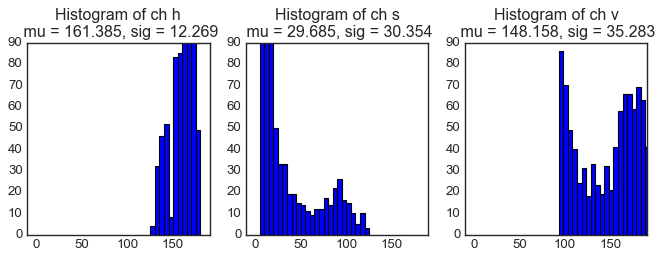

In [45]:
get_distribution = tlc.statistics.get_distribution_of_channel
image    = image_avg_red
# rangeXY  = ranges_red
rangeXY  = ranges_red[0][0]
channels = "hsv"
mu_h_r, sig_h_r, dist_R = get_distribution( image, channels, 0, rangeXY[0], rangeXY[1] )
mu_s_r, sig_s_r, dist_Y = get_distribution( image, channels, 1, rangeXY[0], rangeXY[1] )
mu_v_r, sig_v_r, dist_G = get_distribution( image, channels, 2, rangeXY[0], rangeXY[1] )

print(f"Distribution of brightness in Average-Red    image: mu_R = {mu_h_r:.3f}, sig_R = {sig_h_r:.3f}")
print(f"Distribution of brightness in Average-Yellow image: mu_Y = {mu_s_r:.3f}, sig_Y = {sig_s_r:.3f}")
print(f"Distribution of brightness in Average-Green  image: mu_G = {mu_v_r:.3f}, sig_G = {sig_v_r:.3f}")

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))

w = 5

ax = ax1; dist = dist_R
ax.set_title(f"Histogram of ch h\n mu = {mu_h_r:.3f}, sig = {sig_h_r:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([  -2,  2])
ax.set_xlim([  -10,  190])
ax.set_ylim([  0,  90])

ax = ax2; dist = dist_Y
ax.set_title(f"Histogram of ch s\n mu = {mu_s_r:.3f}, sig = {sig_s_r:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([  -10,  190])
ax.set_xlim([-10, 190])
ax.set_ylim([  0,  90])

ax = ax3; dist = dist_G
ax.set_title(f"Histogram of ch v\n mu = {mu_v_r:.3f}, sig = {sig_v_r:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 260])
ax.set_xlim([  -10,  190])
ax.set_ylim([  0,  90])


Distribution of brightness in Average-Red    image: mu_R = 104.314, sig_R = 44.564
Distribution of brightness in Average-Yellow image: mu_Y = 21.594, sig_Y = 18.479
Distribution of brightness in Average-Green  image: mu_G = 149.768, sig_G = 34.482


(0.0, 90.0)

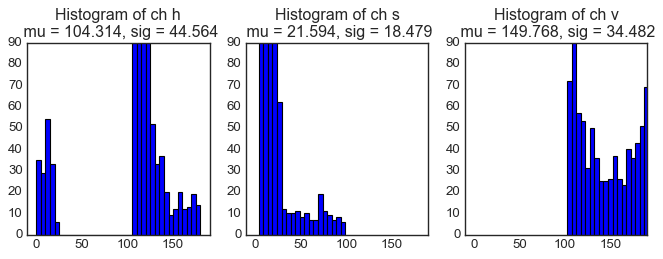

In [46]:
get_distribution = tlc.statistics.get_distribution_of_channel
image    = image_avg_yellow
# rangeXY = ranges_yellow
rangeXY  = ranges_red[0][0]
channels = "hsv"
mu_h_y, sig_h_y, dist_R = get_distribution( image, channels, 0, rangeXY[0], rangeXY[1] )
mu_s_y, sig_s_y, dist_Y = get_distribution( image, channels, 1, rangeXY[0], rangeXY[1] )
mu_v_y, sig_v_y, dist_G = get_distribution( image, channels, 2, rangeXY[0], rangeXY[1] )

print(f"Distribution of brightness in Average-Red    image: mu_R = {mu_h_y:.3f}, sig_R = {sig_h_y:.3f}")
print(f"Distribution of brightness in Average-Yellow image: mu_Y = {mu_s_y:.3f}, sig_Y = {sig_s_y:.3f}")
print(f"Distribution of brightness in Average-Green  image: mu_G = {mu_v_y:.3f}, sig_G = {sig_v_y:.3f}")

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))

w = 5

ax = ax1; dist = dist_R
ax.set_title(f"Histogram of ch h\n mu = {mu_h_y:.3f}, sig = {sig_h_y:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([  -2,  2])
ax.set_xlim([  -10,  190])
ax.set_ylim([  0,  90])

ax = ax2; dist = dist_Y
ax.set_title(f"Histogram of ch s\n mu = {mu_s_y:.3f}, sig = {sig_s_y:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 190])
ax.set_xlim([  -10,  190])
ax.set_ylim([  0,  90])

ax = ax3; dist = dist_G
ax.set_title(f"Histogram of ch v\n mu = {mu_v_y:.3f}, sig = {sig_v_y:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 260])
ax.set_xlim([  -10,  190])
ax.set_ylim([  0,  90])


Distribution of brightness in Average-Red    image: mu_R = 112.102, sig_R = 11.093
Distribution of brightness in Average-Yellow image: mu_Y = 27.563, sig_Y = 29.171
Distribution of brightness in Average-Green  image: mu_G = 146.416, sig_G = 29.104


(0.0, 90.0)

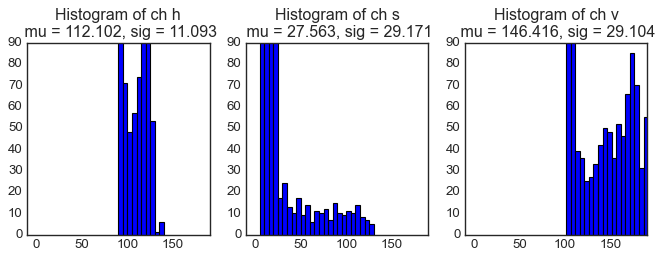

In [47]:
get_distribution = tlc.statistics.get_distribution_of_channel
image    = image_avg_green
rangeXY = ranges_green
rangeXY  = ranges_red[0][0]
channels = "hsv"
mu_h_g, sig_h_g, dist_R = get_distribution( image, channels, 0, rangeXY[0], rangeXY[1] )
mu_s_g, sig_s_g, dist_Y = get_distribution( image, channels, 1, rangeXY[0], rangeXY[1] )
mu_v_g, sig_v_g, dist_G = get_distribution( image, channels, 2, rangeXY[0], rangeXY[1] )

print(f"Distribution of brightness in Average-Red    image: mu_R = {mu_h_g:.3f}, sig_R = {sig_h_g:.3f}")
print(f"Distribution of brightness in Average-Yellow image: mu_Y = {mu_s_g:.3f}, sig_Y = {sig_s_g:.3f}")
print(f"Distribution of brightness in Average-Green  image: mu_G = {mu_v_g:.3f}, sig_G = {sig_v_g:.3f}")

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))

w = 5

ax = ax1; dist = dist_R
ax.set_title(f"Histogram of ch h\n mu = {mu_h_g:.3f}, sig = {sig_h_g:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([  -2,  2])
ax.set_xlim([  -10,  190])
ax.set_ylim([  0,  90])

ax = ax2; dist = dist_Y
ax.set_title(f"Histogram of ch s\n mu = {mu_s_g:.3f}, sig = {sig_s_g:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 190])
ax.set_xlim([  -10,  190])
ax.set_ylim([  0,  90])

ax = ax3; dist = dist_G
ax.set_title(f"Histogram of ch v\n mu = {mu_v_g:.3f}, sig = {sig_v_g:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 260])
ax.set_xlim([  -10,  190])
ax.set_ylim([  0,  90])


# RGB

Distribution of brightness in Average-Red    image: mu_R = 147.828, sig_R = 35.734
Distribution of brightness in Average-Yellow image: mu_Y = 129.739, sig_Y = 32.312
Distribution of brightness in Average-Green  image: mu_G = 135.578, sig_G = 30.893


(0.0, 80.0)

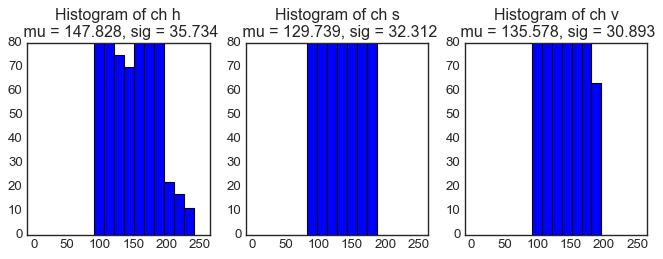

In [48]:
get_distribution = tlc.statistics.get_distribution_of_channel
image    = image_avg_red
rangeXY  = ranges_red[0][0]
channels = "rgb"
mu_r_r, sig_r_r, dist_R = get_distribution( image, channels, 0, rangeXY[0], rangeXY[1] )
mu_g_r, sig_g_r, dist_Y = get_distribution( image, channels, 1, rangeXY[0], rangeXY[1] )
mu_b_r, sig_b_r, dist_G = get_distribution( image, channels, 2, rangeXY[0], rangeXY[1] )

print(f"Distribution of brightness in Average-Red    image: mu_R = {mu_r_r:.3f}, sig_R = {sig_r_r:.3f}")
print(f"Distribution of brightness in Average-Yellow image: mu_Y = {mu_g_r:.3f}, sig_Y = {sig_g_r:.3f}")
print(f"Distribution of brightness in Average-Green  image: mu_G = {mu_b_r:.3f}, sig_G = {sig_b_r:.3f}")

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))

w = 15

ax = ax1; dist = dist_R
ax.set_title(f"Histogram of ch h\n mu = {mu_r_r:.3f}, sig = {sig_r_r:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  80])

ax = ax2; dist = dist_Y
ax.set_title(f"Histogram of ch s\n mu = {mu_g_r:.3f}, sig = {sig_g_r:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  80])

ax = ax3; dist = dist_G
ax.set_title(f"Histogram of ch v\n mu = {mu_b_r:.3f}, sig = {sig_b_r:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  80])


Distribution of brightness in Average-Red    image: mu_R = 144.001, sig_R = 33.937
Distribution of brightness in Average-Yellow image: mu_Y = 140.729, sig_Y = 34.069
Distribution of brightness in Average-Green  image: mu_G = 143.395, sig_G = 34.088


(0.0, 80.0)

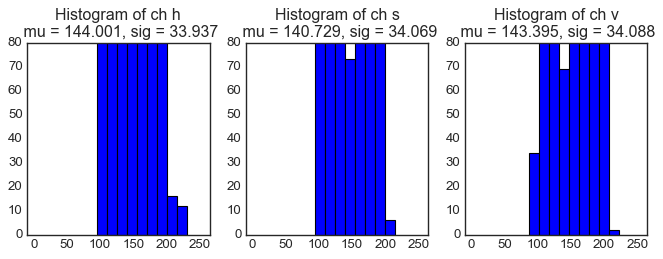

In [49]:
get_distribution = tlc.statistics.get_distribution_of_channel
image    = image_avg_yellow
rangeXY  = ranges_red[0][0]
mu_r_y, sig_r_y, dist_R = get_distribution( image, channels, 0, rangeXY[0], rangeXY[1] )
mu_g_y, sig_g_y, dist_Y = get_distribution( image, channels, 1, rangeXY[0], rangeXY[1] )
mu_b_y, sig_b_y, dist_G = get_distribution( image, channels, 2, rangeXY[0], rangeXY[1] )

print(f"Distribution of brightness in Average-Red    image: mu_R = {mu_r_y:.3f}, sig_R = {sig_r_y:.3f}")
print(f"Distribution of brightness in Average-Yellow image: mu_Y = {mu_g_y:.3f}, sig_Y = {sig_g_y:.3f}")
print(f"Distribution of brightness in Average-Green  image: mu_G = {mu_b_y:.3f}, sig_G = {sig_b_y:.3f}")

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))

w = 15

ax = ax1; dist = dist_R
ax.set_title(f"Histogram of ch h\n mu = {mu_r_y:.3f}, sig = {sig_r_y:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  80])

ax = ax2; dist = dist_Y
ax.set_title(f"Histogram of ch s\n mu = {mu_g_y:.3f}, sig = {sig_g_y:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  80])

ax = ax3; dist = dist_G
ax.set_title(f"Histogram of ch v\n mu = {mu_b_y:.3f}, sig = {sig_b_y:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  80])


Distribution of brightness in Average-Red    image: mu_R = 130.755, sig_R = 32.112
Distribution of brightness in Average-Yellow image: mu_Y = 140.683, sig_Y = 30.176
Distribution of brightness in Average-Green  image: mu_G = 146.408, sig_G = 29.091


(0.0, 80.0)

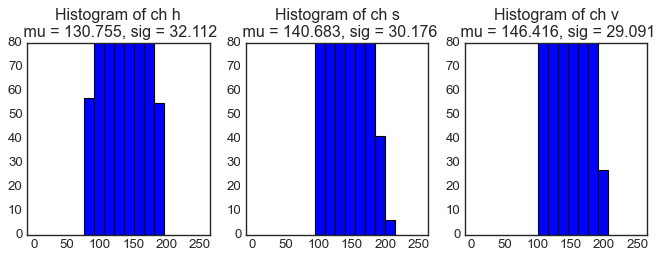

In [50]:
get_distribution = tlc.statistics.get_distribution_of_channel
image    = image_avg_green
# rangeXY = ranges_green
rangeXY  = ranges_red[0][0]
channels = "rgb"
mu_r_g, sig_r_g, dist_R = get_distribution( image, channels, 0, rangeXY[0], rangeXY[1] )
mu_g_g, sig_g_g, dist_Y = get_distribution( image, channels, 1, rangeXY[0], rangeXY[1] )
mu_b_g, sig_b_g, dist_G = get_distribution( image, channels, 2, rangeXY[0], rangeXY[1] )

print(f"Distribution of brightness in Average-Red    image: mu_R = {mu_r_g:.3f}, sig_R = {sig_r_g:.3f}")
print(f"Distribution of brightness in Average-Yellow image: mu_Y = {mu_g_g:.3f}, sig_Y = {sig_g_g:.3f}")
print(f"Distribution of brightness in Average-Green  image: mu_G = {mu_b_g:.3f}, sig_G = {sig_b_g:.3f}")

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))

w = 15

ax = ax1; dist = dist_R
ax.set_title(f"Histogram of ch h\n mu = {mu_r_g:.3f}, sig = {sig_r_g:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  80])

ax = ax2; dist = dist_Y
ax.set_title(f"Histogram of ch s\n mu = {mu_g_g:.3f}, sig = {sig_g_g:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  80])

ax = ax3; dist = dist_G
ax.set_title(f"Histogram of ch v\n mu = {mu_v_g:.3f}, sig = {sig_b_g:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  80])


# Probability

In [51]:
from scipy.stats import norm

In [52]:
mu_h_r

161.3850156087409

In [53]:
# def get_probabilities(image_rgb):
    
# #     len_range = (10,8)
# #     get_range_of_high_average_channel = tlc.extract_feature.get_range_of_high_average_channel
# #     range_s, _ = get_range_of_high_average_channel(image_rgb, "s", len_range)
    
# #     crop = tlc.modify_images.crop_image
# #     image_cropped = crop(image_rgb, range_s[0], range_s[1])
    
# #     get_distribution = tlc.statistics.get_distribution_of_channel
# #     image    = image_cropped
# #     rangeXY  = range_s
    
#     image_cropped = image_rgb
    
#     hue_average, _, _ = get_distribution( image, "rgb", 0, rangeXY[0], rangeXY[1] )
#     sat_average, _, _ = get_distribution( image, "rgb", 1, rangeXY[0], rangeXY[1] )
#     val_average, _, _ = get_distribution( image, "rgb", 2, rangeXY[0], rangeXY[1] )
    
#     print(f"Average Hue        = {hue_average}")
#     print(f"Average Saturation = {sat_average}")
#     print(f"Average brightness = {val_average}")
    
# #     ll_h_red    = norm.pdf(hue_average, mu_h_r, sig_h_r)
# #     ll_h_yellow = norm.pdf(hue_average, mu_h_y, sig_h_y)
# #     ll_h_green  = norm.pdf(hue_average, mu_h_g, sig_h_g)
    
# #     ll_s_red    = norm.pdf(sat_average, mu_s_r, 100*100)
# #     ll_s_yellow = norm.pdf(sat_average, mu_s_y, 100*100)
# #     ll_s_green  = norm.pdf(sat_average, mu_s_g, 100*100)
    
# #     ll_v_red    = norm.pdf(val_average, mu_v_r, 100*100)
# #     ll_v_yellow = norm.pdf(val_average, mu_v_y, 100*100)
# #     ll_v_green  = norm.pdf(val_average, mu_v_g, 100*100)
    
#     ll_h_red    = norm.pdf(hue_average, mu_r_r, sig_r_r)
#     ll_h_yellow = norm.pdf(hue_average, mu_r_y, sig_r_y)
#     ll_h_green  = norm.pdf(hue_average, mu_r_g, sig_r_g)
#     ll_h      = ll_h_red
    
#     ll_s_red    = norm.pdf(sat_average, mu_g_r, sig_g_r)
#     ll_s_yellow = norm.pdf(sat_average, mu_g_y, sig_g_y)
#     ll_s_green  = norm.pdf(sat_average, mu_g_g, sig_g_g)
#     kk_s        =ll_s_red
    
#     ll_v_red    = norm.pdf(val_average, mu_b_r, sig_b_r)
#     ll_v_yellow = norm.pdf(val_average, mu_b_y, sig_b_y)
#     ll_v_green  = norm.pdf(val_average, mu_b_g, sig_b_g)
#     ll_v_v      = ll_v_red
    
#     ll_red    = ll_h_red    * ll_s_red    + ll_v_red
#     ll_yellow = ll_h_yellow * ll_s_yellow + ll_s_green
#     ll_green  = ll_h_green  * ll_s_green  + ll_v_green
    
# #     ll_red    = np.log(ll_h_red)    # + np.log(ll_s_red)    + np.log(ll_v_red)
# #     ll_yellow = np.log(ll_h_yellow) # + np.log(ll_s_yellow) + np.log(ll_s_green)
# #     ll_green  = np.log(ll_h_green)  # + np.log(ll_s_green)  + np.log(ll_v_green)
    
#     print(f"ll_red    = {ll_red}")
#     print(f"ll_yellow = {ll_yellow}")
#     print(f"ll_green  = {ll_green}")
    
#     deno      = ll_red + ll_yellow + ll_green
    
#     P_being_red    = ll_red    / deno
#     P_being_yellow = ll_yellow / deno
#     P_being_green  = ll_green  / deno
    
#     probabilities = [P_being_red, P_being_yellow, P_being_green]
    
#     return probabilities

# def estimate_label(image_rgb, plot_enabled = False, print_detail = False):
    
#     probabilities = get_probabilities(image_rgb)
    
#     i_max_prob = np.argmax( probabilities )
    
#     if i_max_prob == 0:
#         label = "red"
#     elif i_max_prob == 1:
#         label = "yellow"
#     elif i_max_prob == 2:
#         label = "green"
    
#     if plot_enabled:
#         tlc.plots.plot_images(image_rgb)
    
#     return tlc.helpers.one_hot_encode(label)


In [54]:
def get_colors_from_image( image_rgb,
                           plot_enabled = False ):
    
    image_rgb_original = np.copy(image_rgb)
    
    # Convert to HSV >>
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
    
    # Removing Blueness >>
    lower_blue = np.array([ 80,  0,  0])
    upper_blue = np.array([130,  0,  0])
    mask_color               = cv2.inRange(image_hsv, lower_blue, upper_blue)
    image_hsv[mask_color!=0] = [0,0,0]
    
    # Color list >>
    colors = ["red", "yellow", "green"]
    
    # Define color selection boundaries in HSV values >>
    lower = { "red": np.array([140,  0,  0]), "yellow": np.array([10,  0,  0]), "green": np.array([ 60,  0,  0]) }
    upper = { "red": np.array([180,255,255]), "yellow": np.array([35,255,255]), "green": np.array([100,255,255]) }
    
#     # Define color selection boundaries in HSV values >>
#     lower = { "red": np.array([171,  0,  0]), "yellow": np.array([ 3,  0,  0]), "green": np.array([86,  0,  0]) }
#     upper = { "red": np.array([178,255,255]), "yellow": np.array([27,255,255]), "green": np.array([96,255,255]) }
    
#     # Define color selection boundaries in HSV values >>
#     lower = { "red": np.array([171, 82,113]), "yellow": np.array([ 3, 22, 91]), "green": np.array([86,168, 245]) }
#     upper = { "red": np.array([178,153,263]), "yellow": np.array([27,116,168]), "green": np.array([96,255,80]) }
    
    # Extract colors from the input image >>
    image_colors_out = []
    for color in colors:
        mask_color                 = cv2.inRange(image_hsv, lower[color], upper[color])
        image_color                = np.copy(image_hsv)
        image_color[mask_color==0] = [0,0,0]
        image_color_rgb            = cv2.cvtColor(image_color, cv2.COLOR_HSV2RGB)
        image_colors_out.append(image_color_rgb)
    
    # Plot if requested >>
    if plot_enabled:

        for image_color_out, color in zip(image_colors_out, colors):
            
            hsv = cv2.cvtColor(image_color_out, cv2.COLOR_RGB2HSV)
            
            # HSV channels
            h = hsv[:,:,0]
            s = hsv[:,:,1]
            v = hsv[:,:,2]
            
            # Plot the original input image, extracted colors and the three corresponding hsv channels
            f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 15))
            ax1.set_title(f'Original input image')
            ax1.imshow(image_rgb_original)
            ax2.set_title(f'{color} extracterd')
            ax2.imshow(image_color_out)
            ax3.set_title(f'{color} extracterd H channel')
            ax3.imshow(h, cmap='gray')
            ax4.set_title(f'{color} extracterd S channel')
            ax4.imshow(s, cmap='gray')
            ax5.set_title(f'{color} extracterd V channel')
            ax5.imshow(v, cmap='gray')
            
    return image_colors_out


In [55]:
# colors = get_colors_from_image(images_train_std_red[6][0], plot_enabled = True)

In [56]:
# ==================================================================================================
# START >> FUNCTION >> get_probabilities
# ==================================================================================================
# >>
def get_probabilities(image_rgb):
    
    get_range_of_high_average_channel = tlc.extract_feature.get_range_of_high_average_channel
    get_location_of_light             = tlc.extract_feature.get_location_of_light
    range_s = get_location_of_light(image_rgb)
    
    crop = tlc.modify_images.crop_image
    image_cropped = crop(image_rgb, range_s[0], range_s[1])
    images_colors_extracted = get_colors_from_image( image_cropped, plot_enabled = False )
    
    # Getting strengths (average saturation) of redness, yellowness, greenness >>
    colors           = ["r", "y", "g"]
    strengths_colors = []
    for color, image_color_extracted in zip(colors, images_colors_extracted):
        avg_s = tlc.extract_feature.get_average_channel(  image_color_extracted, channel = "s" )
        strengths_colors.append(avg_s)
    
    sum_strengths_colors = sum(strengths_colors)
    
    # print(f"sum_strengths_colors = {sum_strengths_colors}")
   
    # P_being_red    = strengths_colors[0] / sum_strengths_colors
    # P_being_green  = strengths_colors[1] / sum_strengths_colors
    # P_being_yellow = strengths_colors[2] / sum_strengths_colors
    
    from scipy.special import logsumexp
    P_being_red    = logsumexp(strengths_colors[0]) - logsumexp(sum_strengths_colors)
    P_being_yellow = logsumexp(strengths_colors[1]) - logsumexp(sum_strengths_colors)
    P_being_green  = logsumexp(strengths_colors[2]) - logsumexp(sum_strengths_colors)
    
    probabilities = [P_being_red, P_being_yellow, P_being_green]
    
    return probabilities
# <<
# ==================================================================================================
# END << FUNCTION << get_probabilities
# ==================================================================================================


# ==================================================================================================
# START >> FUNCTION >> estimate_label related
# ==================================================================================================
# >>
def estimate_label(image_rgb, plot_enabled = False, print_detail = False):
    
    probabilities = get_probabilities(image_rgb)
    
    i_max_prob = np.argmax( probabilities )
    
    if i_max_prob == 0:
        label = "red"
    elif i_max_prob == 1:
        label = "yellow"
    elif i_max_prob == 2:
        label = "green"
    
    if plot_enabled:
        tlc.plots.plot_images(image_rgb)
    
    return tlc.helpers.one_hot_encode(label)
# <<
# ==================================================================================================
# END << FUNCTION << get_average_image
# ==================================================================================================

[0, 0, 1]

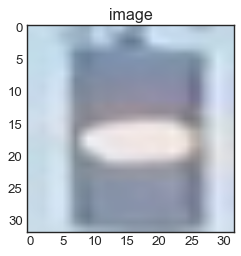

In [57]:
image_rgb = random.choice(images_test_std_yellow)[0]
# image_rgb = images_test_std_yellow[8][0]
estimate_label(image_rgb, plot_enabled = True, print_detail = False)

In [58]:
images_test = tlc.helpers.load_dataset(IMAGE_DIR_TEST)

images_test_red    = [ image for image in images_test if image[1] == "red" ]
images_test_yellow = [ image for image in images_test if image[1] == "yellow" ]
images_test_green  = [ image for image in images_test if image[1] == "green" ]

images_test_std = tlc.modify_images.standardize_images(images_test)

images_test_std_red    = tlc.modify_images.standardize_images(images_test_red)
images_test_std_yellow = tlc.modify_images.standardize_images(images_test_yellow)
images_test_std_green  = tlc.modify_images.standardize_images(images_test_green)


In [59]:
pred_labels_red    = np.array( [ estimate_label(image[0]) for image in images_test_std_red ] )
pred_labels_yellow = np.array( [ estimate_label(image[0]) for image in images_test_std_yellow ] )
pred_labels_green  = np.array( [ estimate_label(image[0]) for image in images_test_std_green ] )

In [60]:
pred_list = []
for image_rgb in images_test_std_red:
    label  = estimate_label(image_rgb[0])
    pred_list.append( label )
pred_red    = pred_list.count([1,0,0])
pred_yellow = pred_list.count([0,1,0])
pred_green  = pred_list.count([0,0,1])
print(f"Total Red images: {len(images_test_std_red)}")
print( f"Pred Red    = {pred_red}" )
print( f"Pred Yellow = {pred_yellow}" )
print( f"Pred Green  = {pred_green}" )


Total Red images: 181
Pred Red    = 181
Pred Yellow = 0
Pred Green  = 0


In [61]:
pred_list = []
for image_rgb in images_test_std_yellow:
    label  = estimate_label(image_rgb[0])
    pred_list.append( label )
pred_red    = pred_list.count([1,0,0])
pred_yellow = pred_list.count([0,1,0])
pred_green  = pred_list.count([0,0,1])
print(f"Total Yellow images: {len(images_test_std_yellow)}")
print( f"Pred Red    = {pred_red}" )
print( f"Pred Yellow = {pred_yellow}" )
print( f"Pred Green  = {pred_green}" )


Total Yellow images: 9
Pred Red    = 1
Pred Yellow = 7
Pred Green  = 1


In [62]:
pred_list = []
for image_rgb in images_test_std_green:
    label  = estimate_label(image_rgb[0])
    pred_list.append( label )
pred_red    = pred_list.count([1,0,0])
pred_yellow = pred_list.count([0,1,0])
pred_green  = pred_list.count([0,0,1])
print(f"Total Green images: {len(images_test_std_green)}")
print( f"Pred Red    = {pred_red}" )
print( f"Pred Yellow = {pred_yellow}" )
print( f"Pred Green  = {pred_green}" )


Total Green images: 107
Pred Red    = 5
Pred Yellow = 3
Pred Green  = 99


In [63]:
# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = tlc.helpers.load_dataset(IMAGE_DIR_TEST)

# Standardize the test data
STANDARDIZED_TEST_LIST = tlc.modify_images.standardize_images(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

In [64]:
# Constructs a list of misclassified images given a list of test images and their labels
# This will throw an AssertionError if labels are not standardized (one-hot encoded)

def get_misclassified_images(test_images):
    # Tracking misclassified images by placing them into a list >>
    misclassified_images_labels = []

    # Iterating through all the test images >>
    # Classifying each image and compare to the true label >>
    for image in test_images:

        # Get true data >>
        im = image[0]
        true_label = image[1]
        assert(len(true_label) == 3), "The true_label is not the expected length (3)."

        # Get predicted label from your classifier >>
        predicted_label = estimate_label(im)
        assert(len(predicted_label) == 3), "The predicted_label is not the expected length (3)."

        # Compare true and predicted labels >>
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified >>
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    # Return the list of misclassified [image, predicted_label, true_label] values >>
    return misclassified_images_labels


# Find all misclassified images in a given test set >>
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST)

# Accuracy calculations >>
total       = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy    = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))


Accuracy: 0.9663299663299664
Number of misclassified images = 10 out of 297


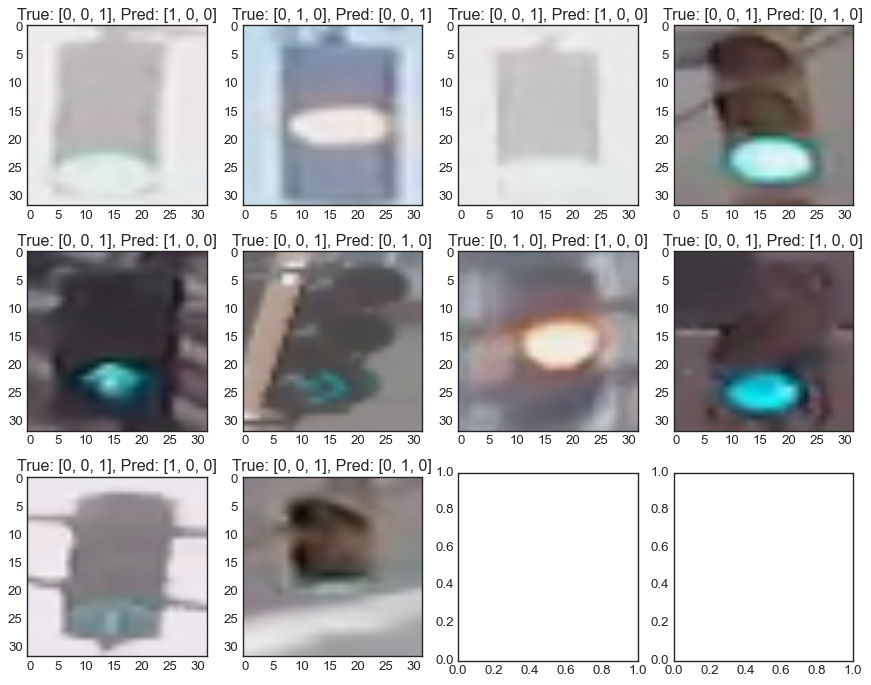

In [65]:
# Visualize misclassified example(s)
## TODO: Display an image in the `MISCLASSIFIED` list 
## TODO: Print out its predicted label - to see what the image *was* incorrectly classified as
tlc.plots.plot_images(MISCLASSIFIED)

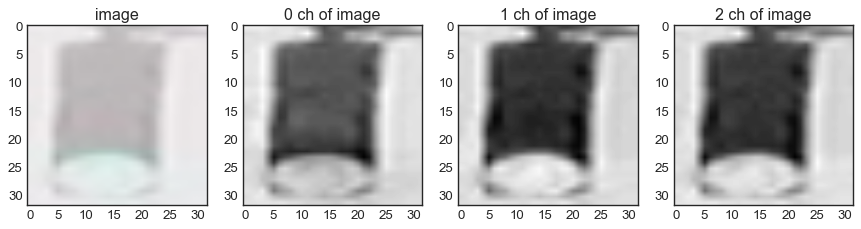

In [66]:
image_rgb = MISCLASSIFIED[0][0]
tlc.plots.plot_channels( image_rgb )

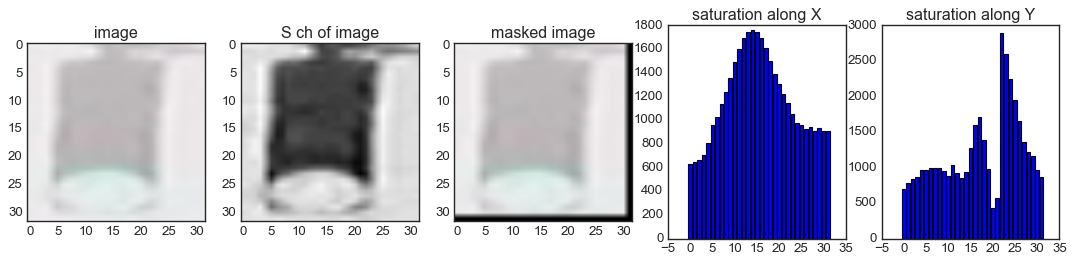

[(0, 31), (0, 31)]

In [67]:
len_range = (10,8)
get_location_of_light = tlc.extract_feature.get_location_of_light
range_s = get_location_of_light(image_rgb, plot_enabled = True)
range_s

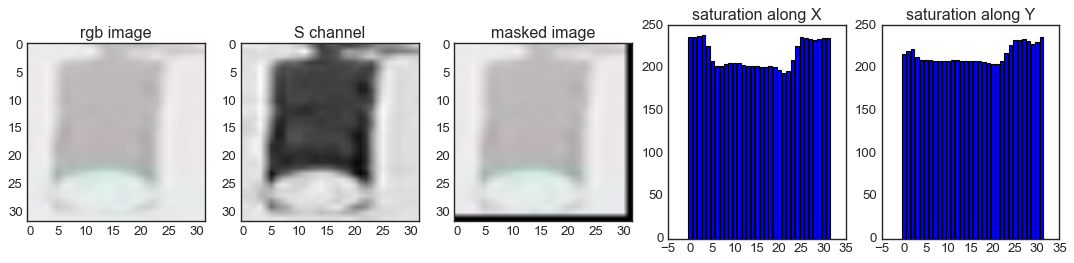

[(0, 31), (0, 31)]

In [68]:
len_range = (10,8)
get_range_of_high_average_channel = tlc.extract_feature.get_range_of_high_average_channel
range_s, _ = get_range_of_high_average_channel(image_rgb, channel = "v", plot_enabled = True)
range_s

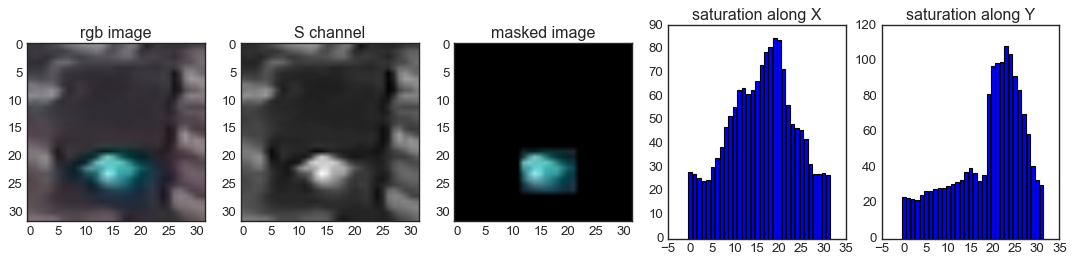

Distribution of brightness in Average-Red    image: mu_h_r = 44.413, sig_h = 12.269
Distribution of brightness in Average-Yellow image: mu_s_r = 105.150, sig_s = 30.354
Distribution of brightness in Average-Green  image: mu_v_r = 111.450, sig_v = 35.283


(0.0, 50.0)

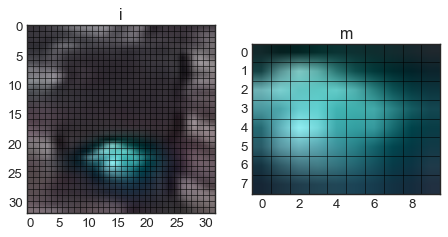

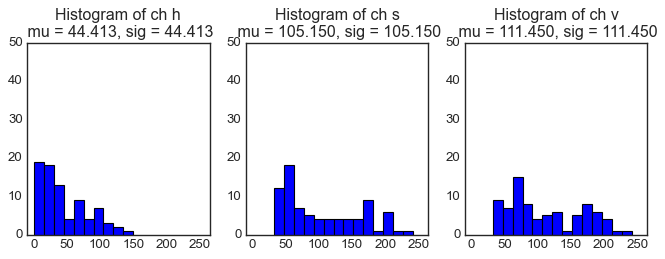

In [69]:
image_rgb = MISCLASSIFIED[4][0]

len_range = (10,8)
get_range_of_high_average_channel = tlc.extract_feature.get_range_of_high_average_channel
range_s, _ = get_range_of_high_average_channel(image_rgb, "s", len_range, plot_enabled = True)

crop = tlc.modify_images.crop_image
image_cropped = crop(image_rgb, range_s[0], range_s[1], plot_enabled = True)

# mu_h_g, sig_h_g, dist_R = get_distribution( image, channels, 0, rangeXY[0], rangeXY[1] )
# get_distribution = tlc.statistics.get_distribution_of_channel

image    = image_cropped
rangeXY  = range_s
mu_h, sig_h, dist_R = get_distribution( image, "rgb", 0, rangeXY[0], rangeXY[1] )
mu_s, sig_s, dist_Y = get_distribution( image, "rgb", 1, rangeXY[0], rangeXY[1] )
mu_v, sig_v, dist_G = get_distribution( image, "rgb", 2, rangeXY[0], rangeXY[1] )

print(f"Distribution of brightness in Average-Red    image: mu_h_r = {mu_h:.3f}, sig_h = {sig_h_r:.3f}")
print(f"Distribution of brightness in Average-Yellow image: mu_s_r = {mu_s:.3f}, sig_s = {sig_s_r:.3f}")
print(f"Distribution of brightness in Average-Green  image: mu_v_r = {mu_v:.3f}, sig_v = {sig_v_r:.3f}")

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))

w = 15

ax = ax1; dist = dist_R
ax.set_title(f"Histogram of ch h\n mu = {mu_h:.3f}, sig = {mu_h:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  50])

ax = ax2; dist = dist_Y
ax.set_title(f"Histogram of ch s\n mu = {mu_s:.3f}, sig = {mu_s:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  50])

ax = ax3; dist = dist_G
ax.set_title(f"Histogram of ch v\n mu = {mu_v:.3f}, sig = {mu_v:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  50])


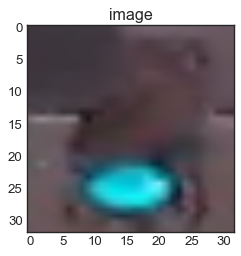

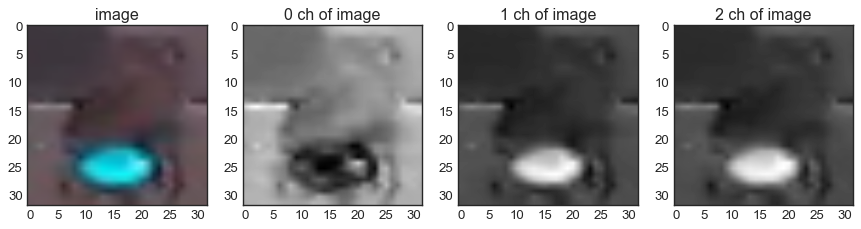

In [70]:
image_rgb = MISCLASSIFIED[7][0]
tlc.plots.plot_images(image_rgb)
tlc.plots.plot_channels(image_rgb, cmap = "gray")

[0, 0, 1]

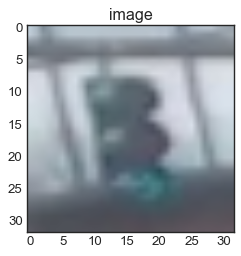

In [71]:
image_rgb = random.choice(images_train_std_green)[0]
# image_rgb = images_train_std_red[0][0]
estimate_label(image_rgb, plot_enabled = True, print_detail = True)

In [72]:
from scipy.special import logsumexp

array1 = np.array([[1100, 1050]])
array2 = np.array([[1200, 4000]])

#perform complex mathematical operation
np.exp(logsumexp(-3*array1) - logsumexp(-3*array2))

logsumexp(10) + logsumexp(10)

20.0

In [73]:
# image_rgb = random.choice(images_train_std_green)[0]
# # image_rgb = images_train_std_red[0][0]
# estimate_label(image_rgb, plot_enabled = True, print_detail = True)

In [74]:
# image_rgb = image_avg_yellow
# tlc.plots.plot_images(image_rgb)
# get_probabilities(image_rgb)

In [75]:
print(f"mu_h_r = {mu_h_r}")
print(f"mu_h_y = {mu_h_y}")
print(f"mu_h_g = {mu_h_g}")

mu_h_r = 161.3850156087409
mu_h_y = 104.31425598335068
mu_h_g = 112.10197710718002


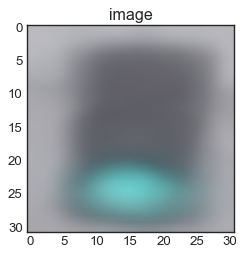

In [76]:
tlc.plots.plot_images(image_avg_green)

In [77]:
# norm.pdf(hue_average, mu_h_r, sig_h_r)

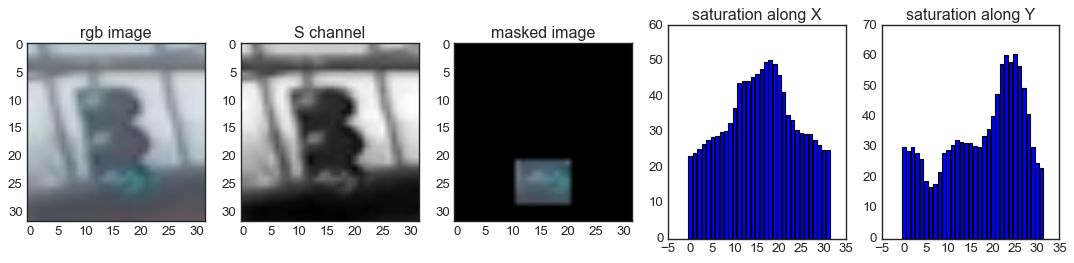

Distribution of brightness in Average-Red    image: mu_h_r = 76.225, sig_h = 12.269
Distribution of brightness in Average-Yellow image: mu_s_r = 98.963, sig_s = 30.354
Distribution of brightness in Average-Green  image: mu_v_r = 110.250, sig_v = 35.283


(0.0, 50.0)

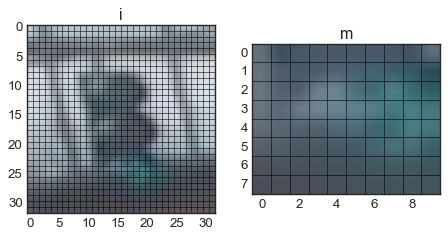

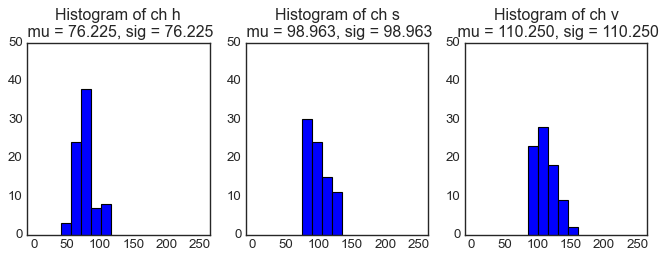

In [78]:
len_range = (10,8)
get_range_of_high_average_channel = tlc.extract_feature.get_range_of_high_average_channel
range_s, _ = get_range_of_high_average_channel(image_rgb, "s", len_range, plot_enabled = True)

crop = tlc.modify_images.crop_image
image_cropped = crop(image_rgb, range_s[0], range_s[1], plot_enabled = True)

# mu_h_g, sig_h_g, dist_R = get_distribution( image, channels, 0, rangeXY[0], rangeXY[1] )
# get_distribution = tlc.statistics.get_distribution_of_channel

image    = image_cropped
rangeXY  = range_s
mu_h, sig_h, dist_R = get_distribution( image, "rgb", 0, rangeXY[0], rangeXY[1] )
mu_s, sig_s, dist_Y = get_distribution( image, "rgb", 1, rangeXY[0], rangeXY[1] )
mu_v, sig_v, dist_G = get_distribution( image, "rgb", 2, rangeXY[0], rangeXY[1] )

print(f"Distribution of brightness in Average-Red    image: mu_h_r = {mu_h:.3f}, sig_h = {sig_h_r:.3f}")
print(f"Distribution of brightness in Average-Yellow image: mu_s_r = {mu_s:.3f}, sig_s = {sig_s_r:.3f}")
print(f"Distribution of brightness in Average-Green  image: mu_v_r = {mu_v:.3f}, sig_v = {sig_v_r:.3f}")

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))

w = 15

ax = ax1; dist = dist_R
ax.set_title(f"Histogram of ch h\n mu = {mu_h:.3f}, sig = {mu_h:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  50])

ax = ax2; dist = dist_Y
ax.set_title(f"Histogram of ch s\n mu = {mu_s:.3f}, sig = {mu_s:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  50])

ax = ax3; dist = dist_G
ax.set_title(f"Histogram of ch v\n mu = {mu_v:.3f}, sig = {mu_v:.3f}")
_ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
ax.set_xlim([  -10,  265])
ax.set_ylim([  0,  50])


In [79]:
mu_h_g

112.10197710718002

In [80]:
# len_range = (10,8)
# get_range_of_high_average_channel = tlc.extract_feature.get_range_of_high_average_channel
# range_s, _ = get_range_of_high_average_channel(image_rgb, "s", len_range, plot_enabled = True)

# crop = tlc.modify_images.crop_image
# image_cropped = crop(image_rgb, range_s[0], range_s[1], plot_enabled = True)

# mu_h_g, sig_h_g, dist_R = get_distribution( image, channels, 0, rangeXY[0], rangeXY[1] )
# get_distribution = tlc.statistics.get_distribution_of_channel

# image    = image_cropped
# rangeXY  = range_s
# mu_h, sig_h, dist_R = get_distribution( image, "hsv", 0, rangeXY[0], rangeXY[1] )
# mu_s, sig_s, dist_Y = get_distribution( image, "hsv", 1, rangeXY[0], rangeXY[1] )
# mu_v, sig_v, dist_G = get_distribution( image, "hsv", 2, rangeXY[0], rangeXY[1] )

# print(f"Distribution of brightness in Average-Red    image: mu_h_r = {mu_h:.3f}, sig_h = {sig_h_r:.3f}")
# print(f"Distribution of brightness in Average-Yellow image: mu_s_r = {mu_s:.3f}, sig_s = {sig_s_r:.3f}")
# print(f"Distribution of brightness in Average-Green  image: mu_v_r = {mu_v:.3f}, sig_v = {sig_v_r:.3f}")

# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))

# w = 15

# ax = ax1; dist = dist_R
# ax.set_title(f"Histogram of ch h\n mu = {mu_h:.3f}, sig = {sig_h:.3f}")
# _ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 190])
# ax.set_ylim([  0,  200])

# ax = ax2; dist = dist_Y
# ax.set_title(f"Histogram of ch s\n mu = {mu_s:.3f}, sig = {sig_s:.3f}")
# _ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 190])
# ax.set_ylim([  0,  200])

# ax = ax3; dist = dist_G
# ax.set_title(f"Histogram of ch v\n mu = {mu_v:.3f}, sig = {sig_v:.3f}")
# _ = ax.hist(dist, bins = np.arange( min(dist), max(dist) + w, w ))
# ax.set_xlim([-10, 260])
# ax.set_ylim([  0,  200])
